In [ ]:
############  m22ai608-Sparse auto-encoders-q1

In [ ]:
#Implement the Sparse auto-encoders (AE). Use the MNIST digit dataset for training your network.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load and preprocess the data using torchvision
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize, shuffle=False, num_workers=4)

#  Define the Sparse Autoencoder class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, sparsity_weight, sparsity_target):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        self.sparsity_weight = sparsity_weight
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#  Create the Sparse Autoencoder model
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 128
sparsity_weight = 0.01
sparsity_target = 0.1

autoencoder = SparseAutoencoder(input_size, hidden_size, sparsity_weight, sparsity_target)

#  Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

#  Train the model
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.view(-1, input_size)

        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Sparsity regularization term
        encoded = autoencoder.encoder(inputs)
        sparsity_loss = torch.mean(torch.abs(encoded - sparsity_target))
        loss += sparsity_weight * sparsity_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader)}")

print("Training finished.")

# Evaluate the model on the test set
autoencoder.eval()
test_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, _ = data
        inputs = inputs.view(-1, input_size)

        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

print(f"Test loss: {test_loss / len(testloader)}")




Epoch 1/50, Loss: 0.10347836005191008
Epoch 2/50, Loss: 0.0550283366193374
Epoch 3/50, Loss: 0.040479355740050474
Epoch 4/50, Loss: 0.034046575985848905
Epoch 5/50, Loss: 0.029917873411128917
Epoch 6/50, Loss: 0.026780018086234727
Epoch 7/50, Loss: 0.024288365337997674
Epoch 8/50, Loss: 0.022298378124833106
Epoch 9/50, Loss: 0.02066790402556459
Epoch 10/50, Loss: 0.019242768517384927
Epoch 11/50, Loss: 0.017960391410936912
Epoch 12/50, Loss: 0.01690591170142094
Epoch 13/50, Loss: 0.01605065632611513
Epoch 14/50, Loss: 0.015294435263300935
Epoch 15/50, Loss: 0.01465656243575116
Epoch 16/50, Loss: 0.014108662012343605
Epoch 17/50, Loss: 0.013628865902622541
Epoch 18/50, Loss: 0.013201171594361464
Epoch 19/50, Loss: 0.012812850003441175
Epoch 20/50, Loss: 0.012458850893502434
Epoch 21/50, Loss: 0.0121353335523357
Epoch 22/50, Loss: 0.011837731022387743
Epoch 23/50, Loss: 0.011559977941215039
Epoch 24/50, Loss: 0.011301776689166824
Epoch 25/50, Loss: 0.011060535193731387
Epoch 26/50, Loss:

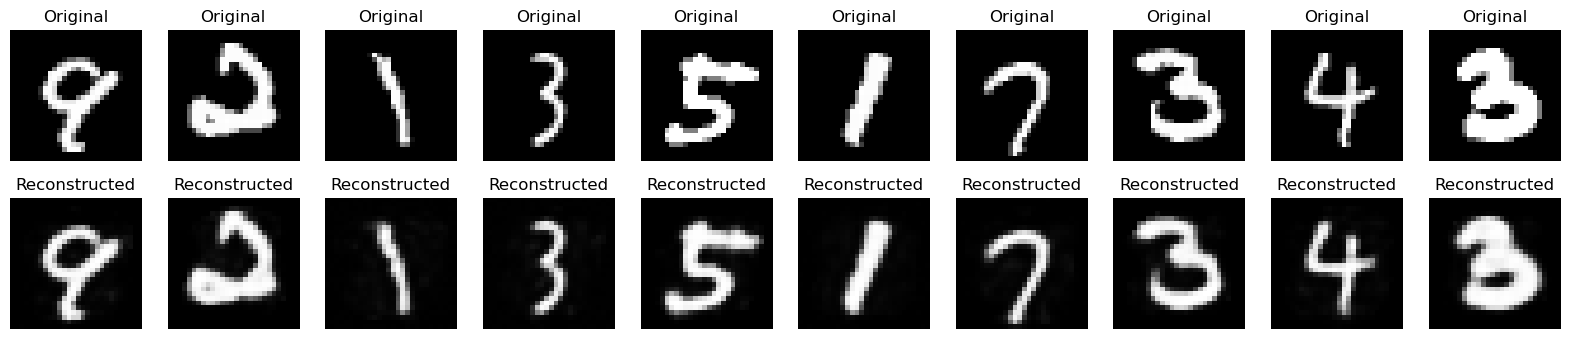

In [2]:
import matplotlib.pyplot as plt
import random

# Visualize the reconstruction
autoencoder.eval()
dataiter = iter(testloader)
inputs, _ = next(dataiter)  # Get a batch of test data
inputs = inputs.view(-1, input_size)

reconstructed = autoencoder(inputs).detach().numpy()

# Choose random samples from the batch for visualization
n = 10
random_indices = random.sample(range(inputs.size(0)), n)

plt.figure(figsize=(20, 4))
for i, idx in enumerate(random_indices):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(inputs[idx].view(28, 28).numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[idx].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [ ]:
#Per-form the k-means clustering on the embeddings. To evaluate the performance of the k-means algorithm,
#use the available labels in the dataset.

In [3]:

import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix


# Generate embeddings using the trained autoencoder
embeddings = []
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.view(-1, input_size)
        encoded = autoencoder.encoder(inputs)
        embeddings.extend(encoded.numpy())

#  Perform k-means clustering on the embeddings
num_clusters = 10  # The number of classes in the MNIST dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

#  Evaluate the k-means clustering performance
true_labels = trainset.targets.numpy()

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(true_labels, cluster_labels)
conf_matrix = confusion_matrix(true_labels, cluster_labels)

print(f"K-means clustering accuracy: {accuracy}")
print("Confusion matrix:")
print(conf_matrix)


K-means clustering accuracy: 0.09985
Confusion matrix:
[[ 638  409  927  567  949  451  373  503  426  680]
 [ 715  497 1055  657 1101  478  432  554  461  792]
 [ 668  387  945  544  955  443  381  445  437  753]
 [ 651  406  918  602 1040  464  372  476  412  790]
 [ 685  375  908  563  901  455  332  489  402  732]
 [ 602  386  863  501  883  450  300  403  378  655]
 [ 607  386  905  578  942  474  374  472  429  751]
 [ 705  386  969  608 1018  512  408  497  425  737]
 [ 608  394  921  580  946  499  346  468  405  684]
 [ 671  393  946  543 1031  450  385  460  388  682]]
